<a href="https://colab.research.google.com/github/stracovskylu/misc_mujoco_test/blob/main/mujoco_contact_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

This is a simple contact test simulation in mujoco which simple objects are held up by contact friction only. The aim of this is to test why some contacts are stable, while others less so (seemingly based on geometry). In each simulation case a different object is held between two red "gripper" blocks with contact force equal to 125% of the object's gravitational acceleration, and accelerated upwards.

The data for each object is shown in a graph that includes:
*   the number of contacts observed between the lifted object and the "gripper" blocks f0 and f1
*   The z position of the held object
*   The z-acceleration of the held object (blue) and also the pre-calculated ideal slip acceleration based off object mass and friction (orange)
*   the normal forces of the contacts between the "gripper" blocks and the object
*   The penetration distances for each contact

Each subgraph also has a vertical red line indicating when the ideal slip acceleration is first exceeded (excluding the initial gripping)

# Setup

In [ ]:
import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

mujoco_dir = "$HOME/.mujoco"

print('Installing OpenGL dependencies...')
!apt-get update -qq
!apt-get install -qq -y --no-install-recommends libglew2.0 > /dev/null

print('Downloading MuJoCo...')
MUJOCO_VERSION = 210
MUJOCO_ARCHIVE = (
    f'mujoco{MUJOCO_VERSION}-{distutils.util.get_platform()}.tar.gz')
!wget -q "https://mujoco.org/download/{MUJOCO_ARCHIVE}"
!wget -q "https://mujoco.org/download/{MUJOCO_ARCHIVE}.sha256"
check_result = !shasum -c "{MUJOCO_ARCHIVE}.sha256"
if _exit_code:
  raise RuntimeError(
      'Downloaded MuJoCo archive is corrupted (checksum mismatch)')

print('Unpacking MuJoCo...')
MUJOCO_DIR = '$HOME/.mujoco'
!mkdir -p "{MUJOCO_DIR}"
!tar -zxf {MUJOCO_ARCHIVE} -C "{MUJOCO_DIR}"

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Installing dm_control...')
# TODO(b/211110746): Upgrade to the latest version once PyPI package is out.
!pip install -q dm_control==0.0.403778684

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del suite, env, pixels


Installing OpenGL dependencies...
Unpacking MuJoCo...
env: MUJOCO_GL=egl
Installing dm_control...
     |████████████████████████████████| 38.6 MB 1.2 MB/s 
     |████████████████████████████████| 4.9 MB 59.6 MB/s 
     |████████████████████████████████| 205 kB 77.5 MB/s 
Checking that the dm_control installation succeeded...


In [ ]:
# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

Exception ignored in: <function _create_finalizer.<locals>.callback at 0x7f62073c7b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/dm_control/mujoco/wrapper/core.py", line 261, in callback
  File "/usr/local/lib/python3.7/dist-packages/dm_control/mujoco/wrapper/core.py", line 802, in finalize_mjr_context
  File "/usr/lib/python3.7/contextlib.py", line 112, in __enter__
  File "/usr/local/lib/python3.7/dist-packages/dm_control/_render/base.py", line 114, in make_current
RuntimeError: Cannot make context <dm_control._render.pyopengl.egl_renderer.EGLContext object at 0x7f62073aec90> current on thread <Thread(_colab_inspector_thread, started daemon 140059149666048)>: this context is already current on another thread <_MainThread(MainThread, started 140059801732992)>.


In [ ]:
# General
import copy
import os
import time
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

# Parameters, XML, and Definitions

In [ ]:
#parameters
density = 1000
size = 0.1
geoms = ["cylinder","sphere","cube_face","cube_edge","cube_corner"]
geoms_xml = [
			"""<geom name="object" type="cylinder" size="{size} {size}"/>""".format(size=size),
			"""<geom name="object" type="sphere" size="{size}"/>""".format(size=size),
            """<geom name="object" type="box" size="{size} {size} {size}"/>""".format(size=size),
			"""<geom name="object" type="box" size="{size} {size} {size}" axisangle="0 0 1 45"/>""".format(size=size),
]
geom_masses = [
               density*np.pi*size**2*(2.0*size),
               density*(4.0/3.0)*np.pi*size**3,
               density*8.0*size**3,
               density*8.0*size**3,
]
gear = 10
print(geom_masses)

[6.283185307179587, 4.188790204786391, 8.000000000000002, 8.000000000000002]


In [ ]:
xml_template_string = """
<mujoco model="contact_test">
	<compiler
		angle="degree"
		inertiafromgeom="auto"
		balanceinertia="true"
	/>
	<option timestep="{dt}"
		cone="elliptic"
		impratio="1"
	/>
	<default>
		<!--<geom solref="0.02 1.0" solimp=".9 .95 .001" condim="4" friction="1.0 0.05 0.05" density="{density}"/>-->
		<geom solref="0.02 1.0" solimp="0.998 0.998 0.001" margin="0" condim="4" friction="1.0 0.05 0.01" density="{density}"/>
	</default>

	<worldbody>
		<geom type="plane" size="1 1 0.1" rgba="0 0 1 0.2"/>

		<body euler="0 0 90">
			<joint name="vertical_gripper" type="slide" axis="0 0 1" limited="true" range="0.008 0.5" damping="5"/>
			<geom type="capsule" fromto="0 0 0.6 0.3 0 0.6" size="0.04" mass="0.1"/>

			<body pos="0 0.3 0.21">
				<joint name="left_finger" type="slide" axis="0 1 0" limited="true" range="-0.2 0" damping="1"/>
				<geom name="f0" type="box" rgba="1 0 0 1" size="0.2 0.07 0.2" density="100"/>
			</body>

			<body pos="0 -0.3 0.21">
				<joint name="right_finger" type="slide" axis="0 1 0" limited="true" range="0 0.2" damping="1"/>
				<geom name="f1" type="box" rgba="1 0 0 1" size="0.2 0.07 0.2" density="100"/>
			</body>
		</body>

		<body pos="0 0 0.3">
			<freejoint/>
            <site name="object_site" type="sphere" size="0.01" rgba="0 0 0.5 0" pos="0 0 0"/>
            {geom_xml}
			<!--<geom name="object" type="cylinder" size="0.1 0.1"/>-->
			<!--<geom name="object" type="sphere" size="0.1"/>-->
			<!--<geom name="object" type="box" size="0.1 0.1 0.1" axisangle="0 0 1 0"/>-->
			<!--<geom name="object" type="box" size="0.1 0.1 0.1" euler="45 45 0"/>-->
		</body>

	</worldbody>

	<equality>
		<joint name="left_box_right_box" joint1="left_finger" joint2="right_finger" polycoef="0 -1 0 0 0"/>
	</equality>

	<actuator>
		<motor name="gripper_motor" gear="{gear}" joint="left_finger"/>
		<motor name="up_motor" gear="{gear}" joint="vertical_gripper"/>
	</actuator>

    <sensor>
        <accelerometer name="object_accel" site="object_site"/>
    </sensor>
</mujoco>
"""

In [16]:
def simulate(physics,xml_string,dt,duration,object_mass,framerate):
    n_steps = int(duration/dt)
    print("num total steps: ",n_steps)

    #data arrays
    sim_time = np.zeros(n_steps)
    object_z = np.zeros(n_steps)
    num_contacts = np.zeros((n_steps,2))
    contact_force = np.zeros((n_steps,2,3))
    contact_dist = np.zeros((n_steps,2))
    object_accel = np.zeros(n_steps)

    forcetorque = np.zeros(6)

    # Visualize the joint axis
    scene_option = mujoco.wrapper.core.MjvOption()
    #scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True

    physics.reset()
    F = 0.5*1.25*object_mass*9.81
    slip_accel = F*2/object_mass
    slip_i_start = 1000 #start checking for the first slip threshold past this index
    #physics.named.data.ctrl["gripper_motor"] = (-F*2.0)/10.0 #scales for the actuator gear and opposite mirrored joint
    #physics.named.data.ctrl["up_motor"] = 0

    #geom pairs of interest: finger geometries and the obejct: names: "f0","f1" and "object"
    f0_i = physics.model.name2id("f0","geom")
    f1_i = physics.model.name2id("f1","geom")
    object_i = physics.model.name2id("object","geom")

    # Simulate and display video.
    frames = []
    #physics.reset()  # Reset state and time
    for i in range(n_steps):
        physics.step()
        if i>500:
            physics.named.data.ctrl["gripper_motor"] = (-F*2.0)/float(gear) #scales for the actuator gear and opposite mirrored joint
            physics.named.data.ctrl["up_motor"]+=0.005
        #record data
        sim_time[i] = physics.data.time
        object_accel[i] = physics.data.sensordata[2]
        object_z[i] = physics.named.data.geom_xpos["object","z"]
        for j,c in enumerate(physics.data.contact): #j is contact index,c is the contact
            k = 0 if f0_i in (c.geom1,c.geom2) else 1 if f1_i in (c.geom1,c.geom2) else -1
            if k>=0 and ( c.geom1==object_i or c.geom2==object_i):
                mjlib.mj_contactForce(physics.model.ptr,physics.data.ptr,j,forcetorque)
                contact_force[i][k]+=forcetorque[0:3]
                contact_dist[i][k] = c.dist #shouldn't be more than one contact per finger/object contact
                num_contacts[i][k]+=1
        if len(frames) < physics.data.time * framerate:
            pixels = physics.render(scene_option=scene_option)
            frames.append(pixels)

    slip_indices = np.where( (object_accel>slip_accel) & (np.arange(len(object_accel))>slip_i_start) )[0]
    slip_i = 0
    if len(slip_indices)>0:
        slip_i = slip_indices[0]
    print("grip force (1 side):",F," slip acceleration:",slip_accel," slip i:",slip_i)
    return n_steps,frames,sim_time,object_z,num_contacts,contact_force,contact_dist,object_accel,slip_i,slip_accel

# Lifting a Sphere

In [17]:
###############################
#OPTIONS
selected_geom = 1 #index corresponds to geom (i.e. 0==cylinder)
dt=0.001
framerate=30
duration=5 #s
###############################

object_mass = geom_masses[selected_geom]
xml_string = xml_template_string.format(dt=dt,density=density,geom_xml=geoms_xml[selected_geom],gear=gear)
physics = mujoco.Physics.from_xml_string(xml_string)
n_steps,frames,sim_time,object_z,num_contacts,contact_force,contact_dist,object_accel,slip_i,slip_accel = simulate(physics,xml_string,dt,duration,object_mass,framerate)
display_video(frames,framerate)

num total steps:  5000
grip force (1 side): 25.682519943096565  slip acceleration: 12.262500000000001  slip i: 2716


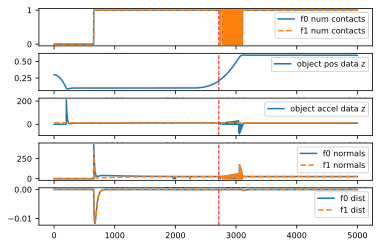

In [ ]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(5,1,1)
ax1.plot(range(n_steps),num_contacts[:,0],label="f0 num contacts")
ax1.plot(range(n_steps),num_contacts[:,1],label="f1 num contacts",linestyle="dashed")
ax1.legend()

ax2 = fig1.add_subplot(5,1,2,sharex=ax1)
ax2.plot(range(n_steps),object_z,label="object pos data z")
ax2.legend()

ax3 = fig1.add_subplot(5,1,3,sharex=ax1)
ax3.plot(range(n_steps),object_accel,label="object accel data z")
ax3.plot(range(n_steps),np.ones(n_steps)*slip_accel,linestyle="dashed")
ax3.legend()

ax4 = fig1.add_subplot(5,1,4,sharex=ax1)
ax4.plot(range(n_steps),contact_force[:,0,0],label="f0 normals",linestyle="solid")
ax4.plot(range(n_steps),contact_force[:,1,0],label="f1 normals",linestyle="dashed")
ax4.legend()

ax5 = fig1.add_subplot(5,1,5,sharex=ax1)
ax5.plot(range(n_steps),contact_dist[:,0],label="f0 dist",linestyle="solid")
ax5.plot(range(n_steps),contact_dist[:,1],label="f1 dist",linestyle="dashed")
ax5.legend()

ax1.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax2.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax3.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax4.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax5.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
plt.show()

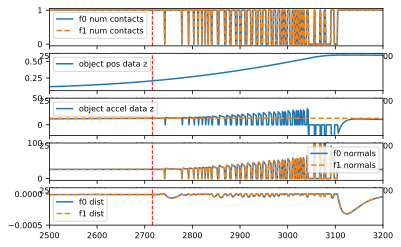

In [ ]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(5,1,1)
ax1.plot(range(n_steps),num_contacts[:,0],label="f0 num contacts")
ax1.plot(range(n_steps),num_contacts[:,1],label="f1 num contacts",linestyle="dashed")
ax1.set_xlim([2500,3200])
ax1.legend()

ax2 = fig1.add_subplot(5,1,2,sharex=ax1)
ax2.plot(range(n_steps),object_z,label="object pos data z")
ax2.legend()

ax3 = fig1.add_subplot(5,1,3,sharex=ax1)
ax3.plot(range(n_steps),object_accel,label="object accel data z")
ax3.plot(range(n_steps),np.ones(n_steps)*slip_accel,linestyle="dashed")
ax3.set_ylim([-20,50])
ax3.legend()

ax4 = fig1.add_subplot(5,1,4,sharex=ax1)
ax4.plot(range(n_steps),contact_force[:,0,0],label="f0 normals",linestyle="solid")
ax4.plot(range(n_steps),contact_force[:,1,0],label="f1 normals",linestyle="dashed")
ax4.set_ylim([-5,100])
ax4.legend()

ax5 = fig1.add_subplot(5,1,5,sharex=ax1)
ax5.plot(range(n_steps),contact_dist[:,0],label="f0 dist",linestyle="solid")
ax5.plot(range(n_steps),contact_dist[:,1],label="f1 dist",linestyle="dashed")
ax5.set_ylim([-0.0005,0.0001])
ax5.legend()

ax1.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax2.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax3.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax4.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax5.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
plt.show()

# Lifting a Cube by opposite edges

In [ ]:
###############################
#OPTIONS
selected_geom = 3 #index corresponds to geom (i.e. 0==cylinder)
dt=0.001
framerate=30
duration=5 #s
###############################

xml_string = xml_template_string.format(dt=dt,density=density,geom_xml=geoms_xml[selected_geom],gear=gear)
physics = mujoco.Physics.from_xml_string(xml_string)
n_steps,frames,sim_time,object_z,num_contacts,contact_force,contact_dist,object_accel,slip_i,slip_accel = simulate(physics,xml_string,dt,duration,framerate)
display_video(frames,framerate)

num total steps:  5000
grip force (1 side): 49.05000000000001  slip acceleration: 12.2625  slip i: 3678


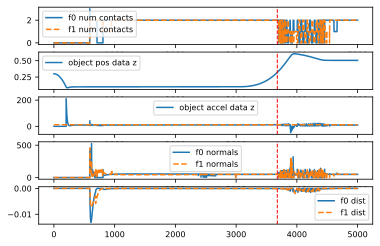

In [ ]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(5,1,1)
ax1.plot(range(n_steps),num_contacts[:,0],label="f0 num contacts")
ax1.plot(range(n_steps),num_contacts[:,1],label="f1 num contacts",linestyle="dashed")
ax1.legend()

ax2 = fig1.add_subplot(5,1,2,sharex=ax1)
ax2.plot(range(n_steps),object_z,label="object pos data z")
ax2.legend()

ax3 = fig1.add_subplot(5,1,3,sharex=ax1)
ax3.plot(range(n_steps),object_accel,label="object accel data z")
ax3.plot(range(n_steps),np.ones(n_steps)*slip_accel,linestyle="dashed")
ax3.legend()

ax4 = fig1.add_subplot(5,1,4,sharex=ax1)
ax4.plot(range(n_steps),contact_force[:,0,0],label="f0 normals",linestyle="solid")
ax4.plot(range(n_steps),contact_force[:,1,0],label="f1 normals",linestyle="dashed")
ax4.legend()

ax5 = fig1.add_subplot(5,1,5,sharex=ax1)
ax5.plot(range(n_steps),contact_dist[:,0],label="f0 dist",linestyle="solid")
ax5.plot(range(n_steps),contact_dist[:,1],label="f1 dist",linestyle="dashed")
ax5.legend()

ax1.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax2.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax3.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax4.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax5.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
plt.show()

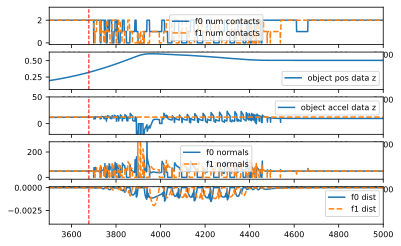

In [ ]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(5,1,1)
ax1.plot(range(n_steps),num_contacts[:,0],label="f0 num contacts")
ax1.plot(range(n_steps),num_contacts[:,1],label="f1 num contacts",linestyle="dashed")
ax1.set_xlim([3500,5000])
ax1.legend()

ax2 = fig1.add_subplot(5,1,2,sharex=ax1)
ax2.plot(range(n_steps),object_z,label="object pos data z")
ax2.legend()

ax3 = fig1.add_subplot(5,1,3,sharex=ax1)
ax3.plot(range(n_steps),object_accel,label="object accel data z")
ax3.plot(range(n_steps),np.ones(n_steps)*slip_accel,linestyle="dashed")
ax3.set_ylim([-20,50])
ax3.legend()

ax4 = fig1.add_subplot(5,1,4,sharex=ax1)
ax4.plot(range(n_steps),contact_force[:,0,0],label="f0 normals",linestyle="solid")
ax4.plot(range(n_steps),contact_force[:,1,0],label="f1 normals",linestyle="dashed")
ax4.set_ylim([-15,280])
ax4.legend()

ax5 = fig1.add_subplot(5,1,5,sharex=ax1)
ax5.plot(range(n_steps),contact_dist[:,0],label="f0 dist",linestyle="solid")
ax5.plot(range(n_steps),contact_dist[:,1],label="f1 dist",linestyle="dashed")
ax5.set_ylim([-0.004,0.0001])
ax5.legend()

ax1.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax2.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax3.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax4.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax5.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
plt.show()

# Lifting a Cylinder

In [ ]:
###############################
#OPTIONS
selected_geom = 0 #index corresponds to geom (i.e. 0==cylinder)
dt=0.001
framerate=30
duration=5 #s
###############################

xml_string = xml_template_string.format(dt=dt,density=density,geom_xml=geoms_xml[selected_geom],gear=gear)
physics = mujoco.Physics.from_xml_string(xml_string)
n_steps,frames,sim_time,object_z,num_contacts,contact_force,contact_dist,object_accel,slip_i,slip_accel = simulate(physics,xml_string,dt,duration,framerate)
display_video(frames,framerate)

num total steps:  5000
grip force (1 side): 38.52377991464484  slip acceleration: 12.2625  slip i: 2452


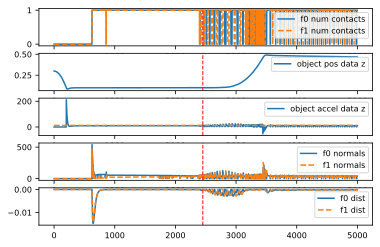

In [ ]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(5,1,1)
ax1.plot(range(n_steps),num_contacts[:,0],label="f0 num contacts")
ax1.plot(range(n_steps),num_contacts[:,1],label="f1 num contacts",linestyle="dashed")
ax1.legend()

ax2 = fig1.add_subplot(5,1,2,sharex=ax1)
ax2.plot(range(n_steps),object_z,label="object pos data z")
ax2.legend()

ax3 = fig1.add_subplot(5,1,3,sharex=ax1)
ax3.plot(range(n_steps),object_accel,label="object accel data z")
ax3.plot(range(n_steps),np.ones(n_steps)*slip_accel,linestyle="dashed")
ax3.legend()

ax4 = fig1.add_subplot(5,1,4,sharex=ax1)
ax4.plot(range(n_steps),contact_force[:,0,0],label="f0 normals",linestyle="solid")
ax4.plot(range(n_steps),contact_force[:,1,0],label="f1 normals",linestyle="dashed")
ax4.legend()

ax5 = fig1.add_subplot(5,1,5,sharex=ax1)
ax5.plot(range(n_steps),contact_dist[:,0],label="f0 dist",linestyle="solid")
ax5.plot(range(n_steps),contact_dist[:,1],label="f1 dist",linestyle="dashed")
ax5.legend()

ax1.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax2.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax3.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax4.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax5.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
plt.show()

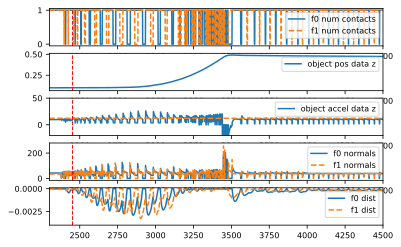

In [ ]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(5,1,1)
ax1.plot(range(n_steps),num_contacts[:,0],label="f0 num contacts")
ax1.plot(range(n_steps),num_contacts[:,1],label="f1 num contacts",linestyle="dashed")
ax1.set_xlim([2300,4500])
ax1.legend()

ax2 = fig1.add_subplot(5,1,2,sharex=ax1)
ax2.plot(range(n_steps),object_z,label="object pos data z")
ax2.legend()

ax3 = fig1.add_subplot(5,1,3,sharex=ax1)
ax3.plot(range(n_steps),object_accel,label="object accel data z")
ax3.plot(range(n_steps),np.ones(n_steps)*slip_accel,linestyle="dashed")
ax3.set_ylim([-20,50])
ax3.legend()

ax4 = fig1.add_subplot(5,1,4,sharex=ax1)
ax4.plot(range(n_steps),contact_force[:,0,0],label="f0 normals",linestyle="solid")
ax4.plot(range(n_steps),contact_force[:,1,0],label="f1 normals",linestyle="dashed")
ax4.set_ylim([-15,280])
ax4.legend()

ax5 = fig1.add_subplot(5,1,5,sharex=ax1)
ax5.plot(range(n_steps),contact_dist[:,0],label="f0 dist",linestyle="solid")
ax5.plot(range(n_steps),contact_dist[:,1],label="f1 dist",linestyle="dashed")
ax5.set_ylim([-0.004,0.0001])
ax5.legend()

ax1.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax2.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax3.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax4.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
ax5.axvline(x=slip_i,color="r",linewidth=1.0, linestyle='--')
plt.show()